A notebook for processing images acquired with the OROCHI simulator to reflectance, with coalignment by stereo geometric calibration.

Processing of Experiments performed on 26/04/2023

- Reflectance Calibration
- Geometric Calibration
- Sample 1
- Sample 2
- Sample 3
- Sample 4 (failed)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Overview

The steps of processing are:
1. Calibration Preparation:
    - Load, average and bias correct Calibration Target images
    - Correct for exposure
    - Load reference reflectance for each channel
    - Scale images to give reflectance calibration coefficient for each pixel
    - Optional: mask for Calibration Target
    - Save reflectance calibration images
3. Geometric Calibration
    - Load, average and bias correct Geometric images
    - Balance images (TBD)
    - Extract camera geometric calibration coefficients (TBD)    
2. Sample Reflectance Calibration and Coalignment
    - Load, average and bias correct Sample images
    - Correct for exposure
    - Apply calibration coefficient frames
    - Optional: mask for Calibration Target area and Sample area.
    - Save reflectance images
    - Apply geometric coalignment
    - Save coaligned images over Region of Interest


# Setup

In [2]:
import orochi_sim_proc as osp
from pathlib import Path
import matplotlib.pyplot as plt

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_ctrl.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
def grid_plot(title: str=None):
    cam_ax = {}
    fig, ax = plt.subplots(3,3, sharex='all', sharey='all', figsize=(10,10))
    cam_ax[6] = ax[0][0]
    cam_ax[1] = ax[0][1]
    cam_ax[3] = ax[0][2]
    cam_ax[4] = ax[1][0]
    cam_ax[0] = ax[1][2]
    cam_ax[7] = ax[2][1]
    cam_ax[5] = ax[2][2]
    cam_ax[2] = ax[2][0] # empty
    cam_ax[8] = ax[1][1] # empty
    fig.suptitle(title)
    return fig, cam_ax

def show_grid(fig, ax):
    # fig.delaxes(ax[2]) # empty
    # fig.delaxes(ax[8]) # empty
    ax[2].set_axis_off()
    ax[8].set_axis_off()    
    fig.tight_layout()
    fig.show()

# Calibration Preparation
For each channel:
- Load, average and bias correct Calibration Target images
- Correct for exposure
- Load reference reflectance for each channel
- Scale images to give reflectance calibration coefficient for each pixel
- Optional: mask for Calibration Target
- Save reflectance calibration images

Finding Reflectance Correction for: 0 (650 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:339: RuntimeWarning: divide by zero encountered in divide
  self.img_stk = self.reference_reflectance / self.img_stk
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:340: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.reference_reflectance / self.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:341: RuntimeWarning: divide by zero encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:341: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave


Finding Reflectance Correction for: 1 (475 nm)
Finding Reflectance Correction for: 3 (400 nm)
Finding Reflectance Correction for: 4 (725 nm)
Finding Reflectance Correction for: 5 (850 nm)
Finding Reflectance Correction for: 6 (550 nm)
Finding Reflectance Correction for: 7 (950 nm)


/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


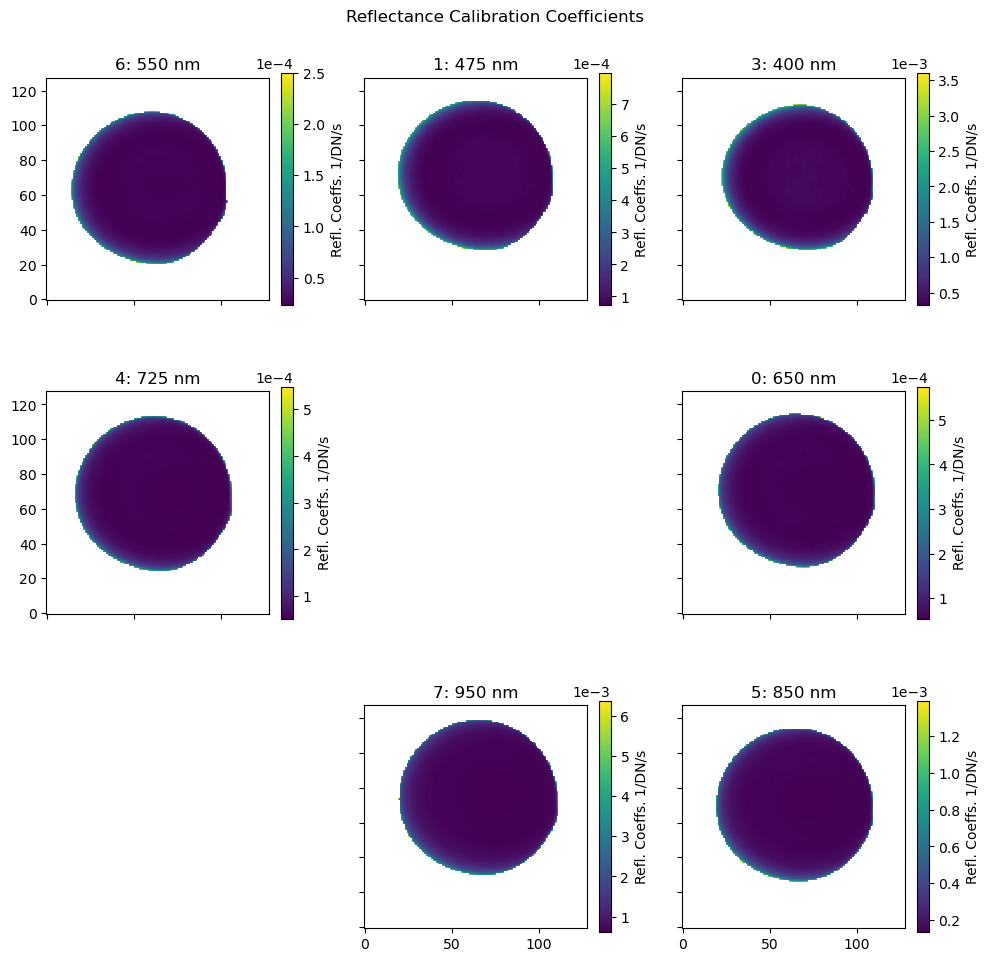

In [4]:
target = 'reflectance_calibration'
channels = sorted(list(Path('..', 'data', target).glob('[!.]*')))
cali_coeffs = {} # store the calibration objects in a dictionary
title = 'Reflectance Calibration Coefficients'
fig, ax = grid_plot(title)
for channel_path in channels:
    channel = channel_path.name
    # load the calibration target images
    cali = osp.LightImage(target, channel)
    cali.image_load()    
    print(f'Finding Reflectance Correction for: {cali.camera} ({int(cali.cwl)} nm)')

    # load the calibration target dark frames
    dark_cali = osp.DarkImage(target, channel)
    dark_cali.image_load()
    # check the mean level
    
    # subtract the dark frame
    cali.dark_subtract(dark_cali)
    # apply exposure correction
    cali.correct_exposure()
    # compute calibration coefficient image
    cali_coeff = osp.CalibrationImage(cali)
    cali_coeff.mask_target()
    cali_coeff.compute_reflectance_coefficients()    
    cali_coeff.image_display(roi=True, ax=ax[cali_coeff.camera])
    cali_coeffs[channel] = cali_coeff
show_grid(fig, ax)

# Homography Calibration

Here we attempt to co-align images by finding the homography matrix between images of the calibration target cap writing.

- Load, average and bias correct geometric images
- choose destination/base image
- for each channel, find homography matrix mapping from channel/source to base
- apply image transformation for each channel.

Load the images

Loading Geometric Target for: 0 (650.0 nm)
Loading Geometric Target for: 1 (475.0 nm)
Loading Geometric Target for: 3 (400.0 nm)
Loading Geometric Target for: 4 (725.0 nm)
Loading Geometric Target for: 5 (850.0 nm)
Loading Geometric Target for: 6 (550.0 nm)
Loading Geometric Target for: 7 (950.0 nm)


/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


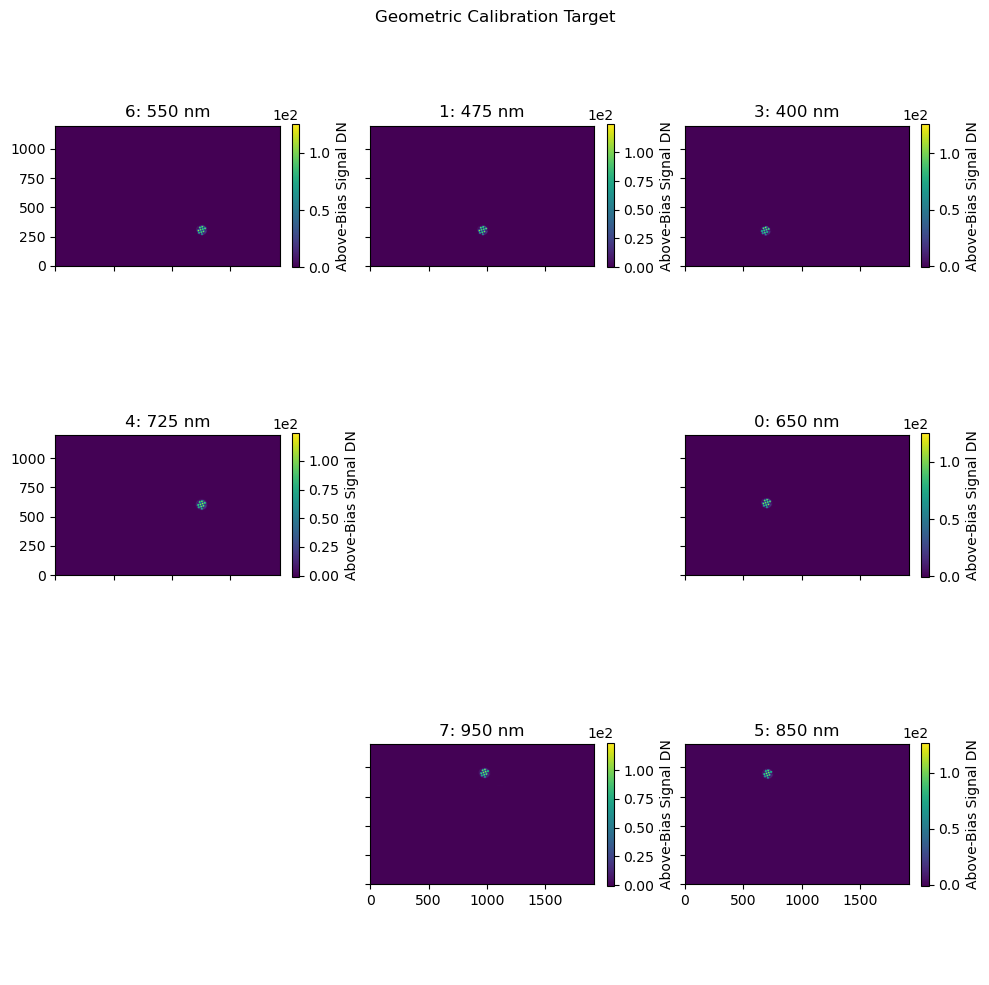

In [5]:
target = 'geometric_calibration'
channels = sorted(list(Path('..', 'data',target).glob('[!_]*')))
geocs = {}
fig, ax = grid_plot('Geometric Calibration Target')
for channel_path in channels:
    channel = channel_path.name
    # load the geometric calibration images
    geoc = osp.LightImage(target, channel)
    geoc.image_load()
    print(f'Loading Geometric Target for: {geoc.camera} ({geoc.cwl} nm)')
    # load the geometric calibration dark frames
    dark_geoc = osp.DarkImage(target, channel)
    dark_geoc.image_load()
    # subtract the dark frame
    geoc.dark_subtract(dark_geoc)
    geoc.image_display(roi=False, ax=ax[geoc.camera])
    geocs[channel] = geoc
show_grid(fig, ax)

Learn transform

Calibrating Homography for: 0 (650.0 nm)
...426 source points found
...426 destination points found
...340 matches found
Calibrating Homography for: 1 (475.0 nm)
...415 source points found
...426 destination points found
...332 matches found
Calibrating Homography for: 3 (400.0 nm)
...403 source points found
...426 destination points found
...322 matches found
Calibrating Homography for: 4 (725.0 nm)
...417 source points found


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: invalid value encountered in divide
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: divide by zero encountered in divide
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')


...426 destination points found
...333 matches found
Calibrating Homography for: 5 (850.0 nm)
...420 source points found
...426 destination points found
...336 matches found
Calibrating Homography for: 6 (550.0 nm)
...420 source points found
...426 destination points found
...336 matches found
Calibrating Homography for: 7 (950.0 nm)
...397 source points found
...426 destination points found
...317 matches found


/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


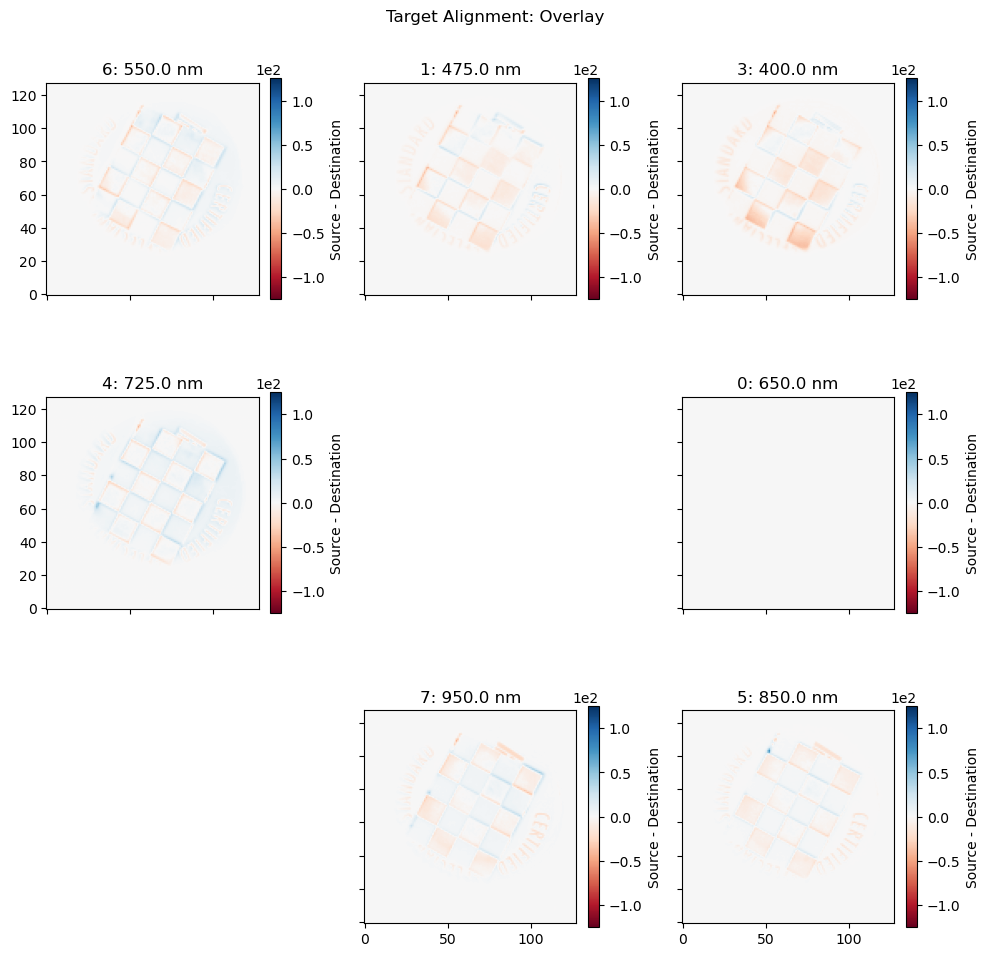

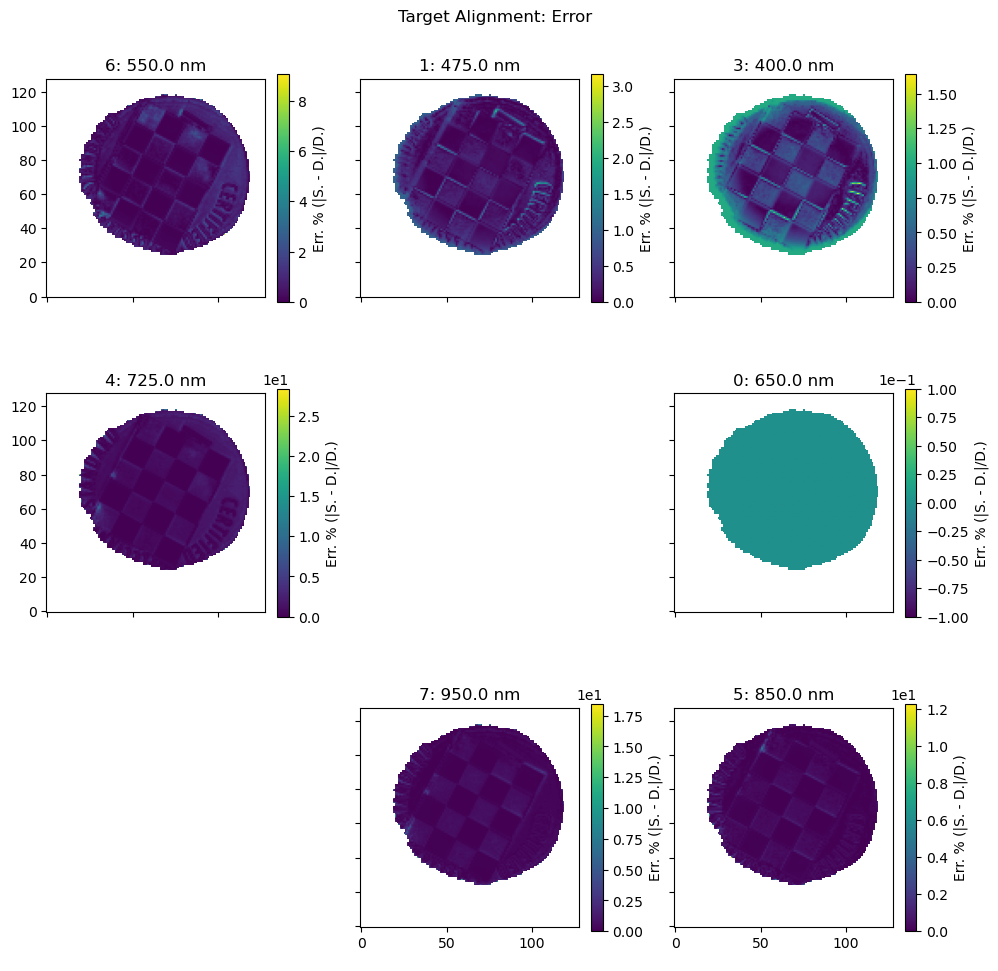

In [6]:
channels = list(geocs.keys())
destination = channels[0]
cali_dest = geocs[destination]
sample_dest = geocs[destination]
coals = {}
fig, ax = grid_plot('Target Alignment: Overlay')
fig1, ax1 = grid_plot('Target Alignment: Error')
for channel in channels:
    cali_src = geocs[channel]    
    src = osp.CoAlignedImage(cali_src, roi=False)
    print(f'Calibrating Homography for: {src.camera} ({src.cwl} nm)')
    n_ps = src.find_points('ORB')
    print(f'...{n_ps} source points found')
    dest = osp.CoAlignedImage(cali_dest, roi=False)
    n_pd = dest.find_points('ORB')
    print(f'...{n_pd} destination points found')
    src.destination = dest
    n_m = src.find_matches('HAMMING')
    print(f'...{n_m} matches found')
    # src.show_matches()
    src.find_homography('RANSAC')
    src.align_images()
    src.show_alignment(overlay=True, error=False, ax=ax[src.camera], roi=True)
    src.show_alignment(overlay=False, error=True, ax=ax1[src.camera], roi=True)
    coals[channel] = src
show_grid(fig, ax)
show_grid(fig1, ax1)


# Sample Reflectance Calibration and Coalignment
- Load, average and bias correct Sample images
- Correct for exposure
- Apply calibration coefficient frames
- Optional: mask for Calibration Target area and Sample area.
- Save reflectance images

## Sample 1

### Reflectance Calibration

Calibrating Reflectance for: 0 (650.0 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:378: RuntimeWarning: invalid value encountered in multiply
  self.img_ave = self.img_ave * cali_source.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:380: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:381: RuntimeWarning: invalid value encountered in divide
  cali_err = cali_source.img_std/cali_source.img_ave


../data/sample_1/0_650
Mean image written to ../data/sample_1/0_650/650_mean_rfl.tif
Error image written to ../data/sample_1/0_650/650_error_rfl.tif
Calibrating Reflectance for: 1 (475.0 nm)
../data/sample_1/1_475
Mean image written to ../data/sample_1/1_475/475_mean_rfl.tif
Error image written to ../data/sample_1/1_475/475_error_rfl.tif
Calibrating Reflectance for: 3 (400.0 nm)
../data/sample_1/3_400
Mean image written to ../data/sample_1/3_400/400_mean_rfl.tif
Error image written to ../data/sample_1/3_400/400_error_rfl.tif
Calibrating Reflectance for: 4 (725.0 nm)
../data/sample_1/4_725
Mean image written to ../data/sample_1/4_725/725_mean_rfl.tif
Error image written to ../data/sample_1/4_725/725_error_rfl.tif
Calibrating Reflectance for: 5 (850.0 nm)
../data/sample_1/5_850
Mean image written to ../data/sample_1/5_850/850_mean_rfl.tif
Error image written to ../data/sample_1/5_850/850_error_rfl.tif
Calibrating Reflectance for: 6 (550.0 nm)
../data/sample_1/6_550
Mean image written to 

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


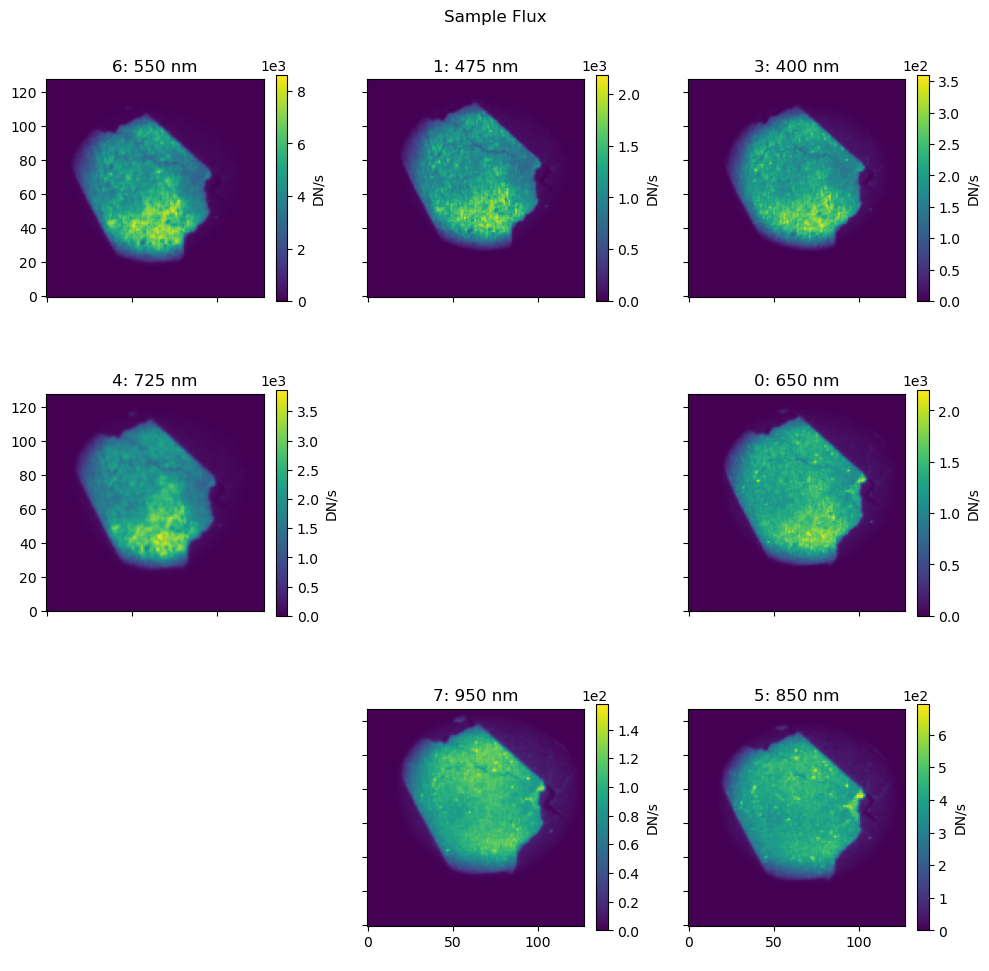

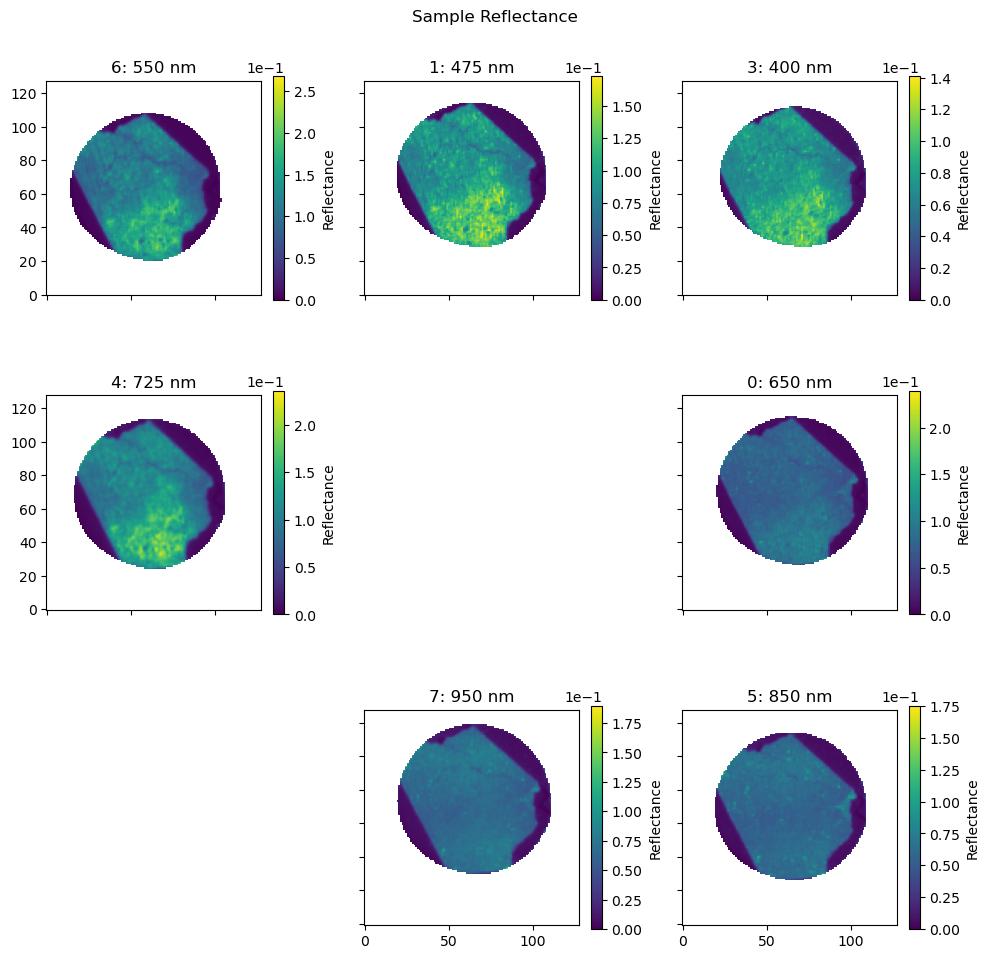

In [7]:
target = 'sample_1'
channels = sorted(list(Path('..', 'data',target).glob('[!.]*')))
reflectance = {}
samples = {}
title = 'Sample Flux'
fig1, ax1 = grid_plot(title)
title = 'Sample Reflectance'
fig, ax = grid_plot(title)
for channel_path in channels:
    channel = channel_path.name
    # load the sample images
    smpl = osp.LightImage(target, channel)
    smpl.image_load()
    print(f'Calibrating Reflectance for: {smpl.camera} ({smpl.cwl} nm)')
    # load the sample dark frames
    dark_smpl = osp.DarkImage(target, channel)
    dark_smpl.image_load()
    # subtract the dark frame
    smpl.dark_subtract(dark_smpl)
    samples[channel] = smpl
    # apply exposure correction
    smpl.correct_exposure()
    smpl.image_display(roi=True, ax=ax1[smpl.camera])
    # apply calibration coefficients
    cali_coeff = cali_coeffs[channel]
    refl = osp.ReflectanceImage(smpl)
    refl.calibrate_reflectance(cali_coeff)
    refl.image_display(roi=True, ax=ax[refl.camera])
    # save the reflectance image
    refl.save_tiff()
    reflectance[channel] = refl
show_grid(fig1, ax1)
show_grid(fig, ax)

### Geometric Alignment

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:548: RuntimeWarning: invalid value encountered in subtract
  src = ax.imshow(query_reg-train_img, cmap='RdBu', origin='lower', vmin=-col_max, vmax=col_max)
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: invalid value encountered in subtract
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


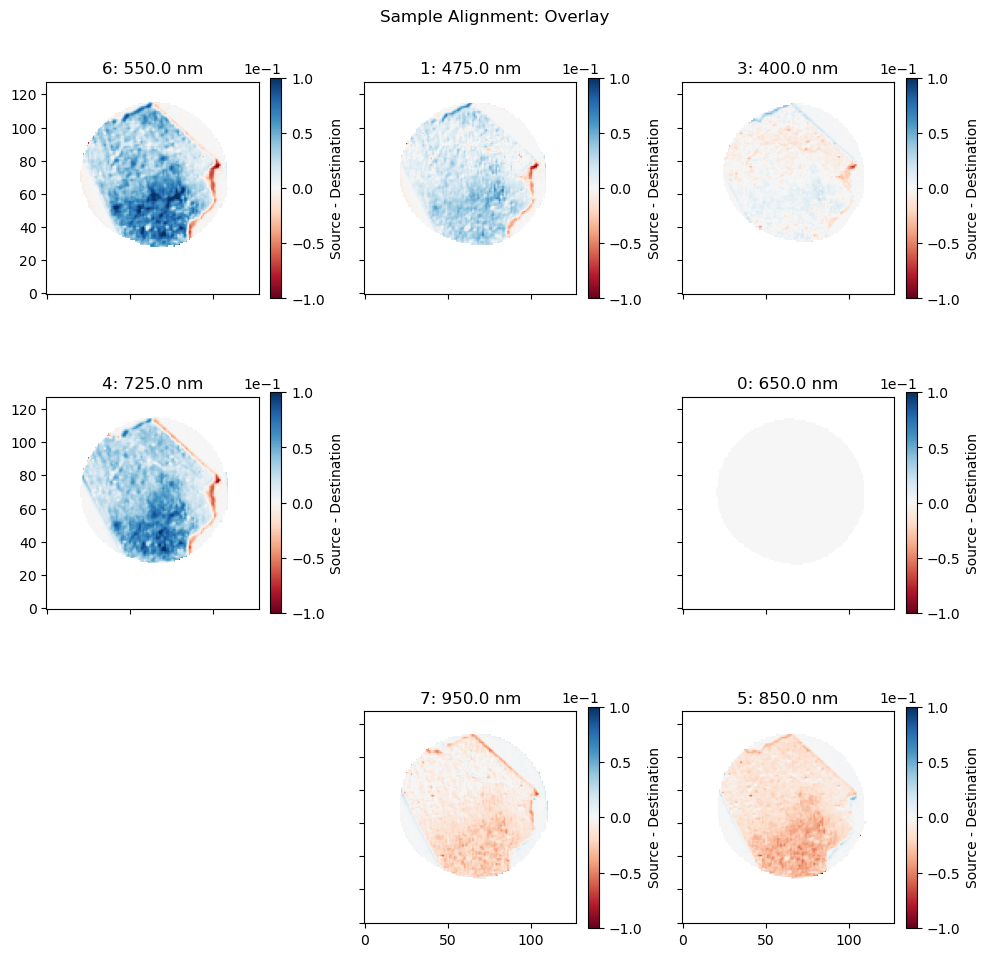

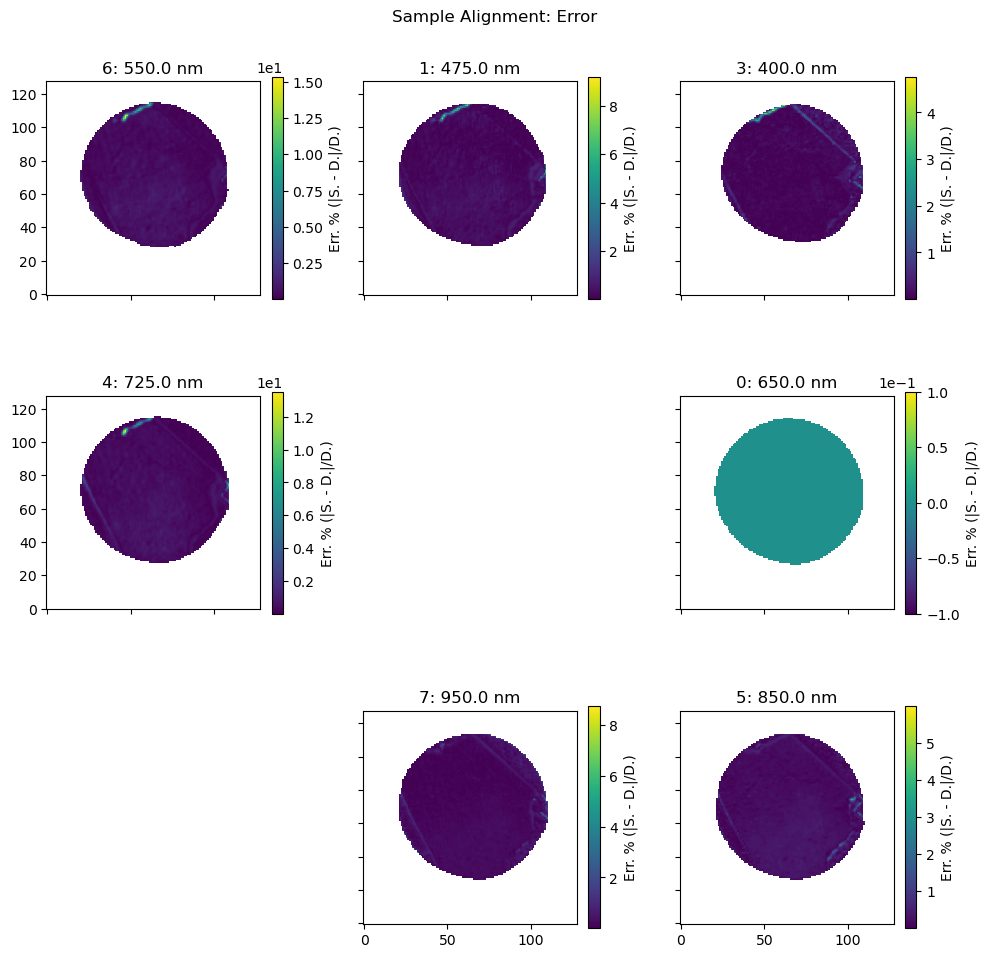

In [8]:
channels = list(reflectance.keys())
destination = channels[0]
sample_dest = reflectance[destination]
fig, ax = grid_plot('Sample Alignment: Overlay')
fig1, ax1 = grid_plot('Sample Alignment: Error')
aligned_refl = {}
for channel in channels:
    sample_src = reflectance[channel] 
    sample_coal = coals[channel]   
    src = osp.CoAlignedImage(
                sample_src, 
                destination_image=sample_dest, 
                homography=sample_coal.homography, 
                roi=False)
    src.align_images()
    src.show_alignment(overlay=True, error=False, ax=ax[src.camera], roi=True)
    src.show_alignment(overlay=False, error=True, ax=ax1[src.camera], roi=True)
    aligned_refl[channel] = osp.ReflectanceImage(src)
show_grid(fig, ax)
show_grid(fig1, ax1)

### Reflectance ROI Selection and Plotting

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:102: RuntimeWarning: invalid value encountered in multiply
  roi_img = roi_img * self.polyroi
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


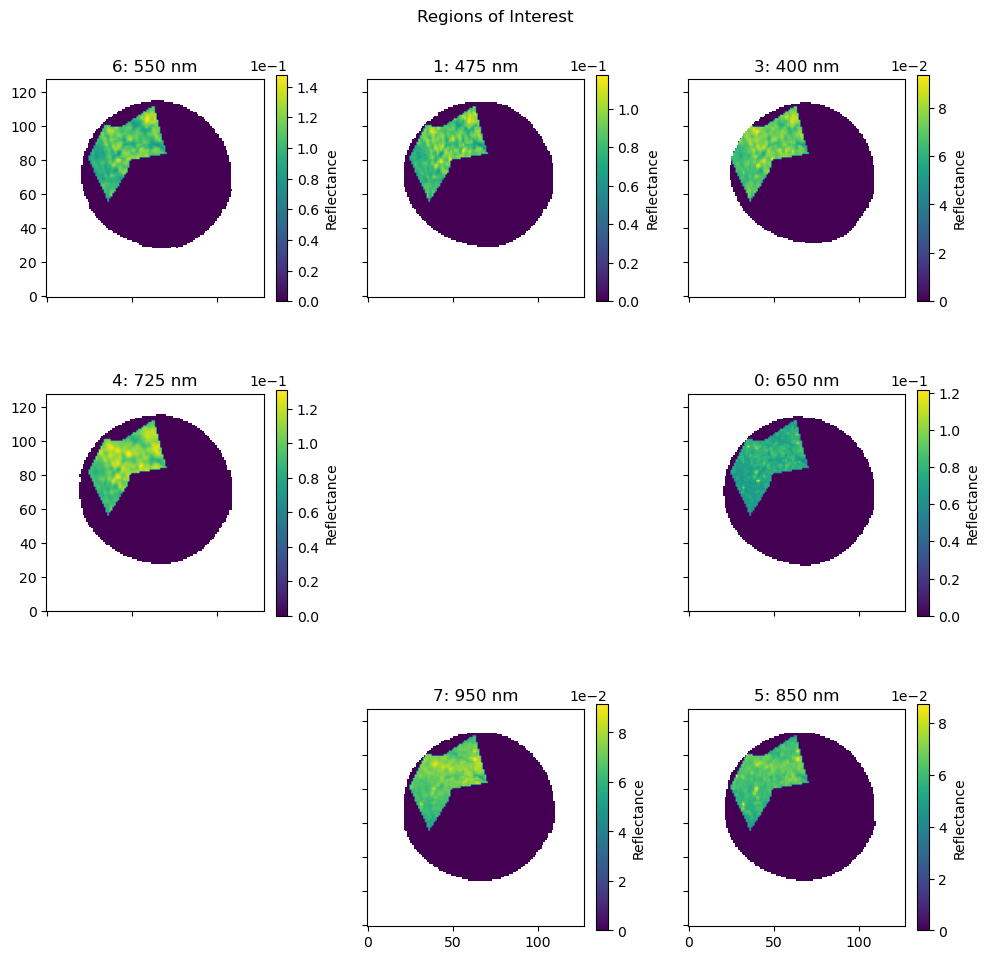

In [9]:
# set region of interest on the base channel
channels = list(aligned_refl.keys())
base = aligned_refl['6_550']
base.roi =True
base.set_polyroi()
# apply the polyroi to each channel:
fig, ax = grid_plot('Regions of Interest')
for channel in channels:
    refl = aligned_refl[channel]
    refl.polyroi = base.polyroi
    refl.image_display(roi=True,polyroi=True, ax=ax[refl.camera])
show_grid(fig, ax)

# for each warped reflectance image, set region of interest mask
# for each warped reflectance image, get average and standard deviation

Average Image Mean: 0.07492565596122969 Reflectance
Average Image Std. Dev.: 0.007063829341760831 Reflectance
Noise Image Mean: 0.0006726400662138074 Reflectance
Average Image Mean: 0.08634354640017906 Reflectance
Average Image Std. Dev.: 0.009739635525270416 Reflectance
Noise Image Mean: 0.0008546810643481091 Reflectance
Average Image Mean: inf Reflectance
Average Image Std. Dev.: nan Reflectance
Noise Image Mean: 0.0007074564705103388 Reflectance
Average Image Mean: 0.10299862265467712 Reflectance
Average Image Std. Dev.: 0.011067227687302034 Reflectance
Noise Image Mean: 0.0009658167895261244 Reflectance
Average Image Mean: 0.06250418939709998 Reflectance
Average Image Std. Dev.: 0.005378752433852465 Reflectance
Noise Image Mean: 0.0005379782821030322 Reflectance
Average Image Mean: 0.10554140180895051 Reflectance
Average Image Std. Dev.: 0.012642675072311394 Reflectance
Noise Image Mean: 0.0010336821767867536 Reflectance
Average Image Mean: 0.06990033324200531 Reflectance
Average I

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


<Axes: xlabel='cwl'>

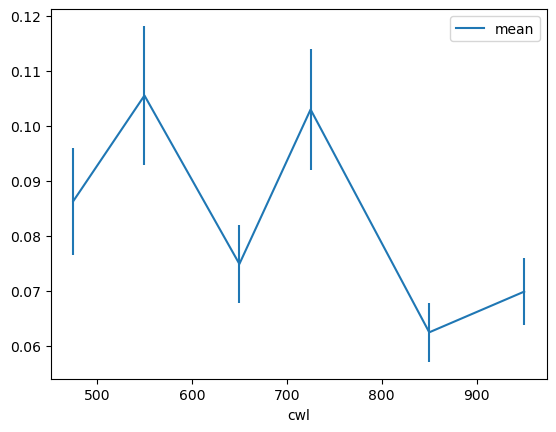

In [10]:
# get the mean and std reflectance over each ROI and plot
import pandas as pd
cwls = []
means = []
stds = []
for channel in channels:
    mean, std, _ = aligned_refl[channel].image_stats(polyroi=True)
    cwl = aligned_refl[channel].cwl
    cwls.append(cwl)
    means.append(mean)
    stds.append(std)
results = pd.DataFrame({'cwl':cwls, 'mean':means, 'std':stds})
results.sort_values(by='cwl', inplace=True)
results.plot(x='cwl', y='mean', yerr='std')

Now normalise the results

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:387: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:387: RuntimeWarning: invalid value encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:102: RuntimeWarning: invalid value encountered in multiply
  roi_img = roi_img * self.polyroi
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


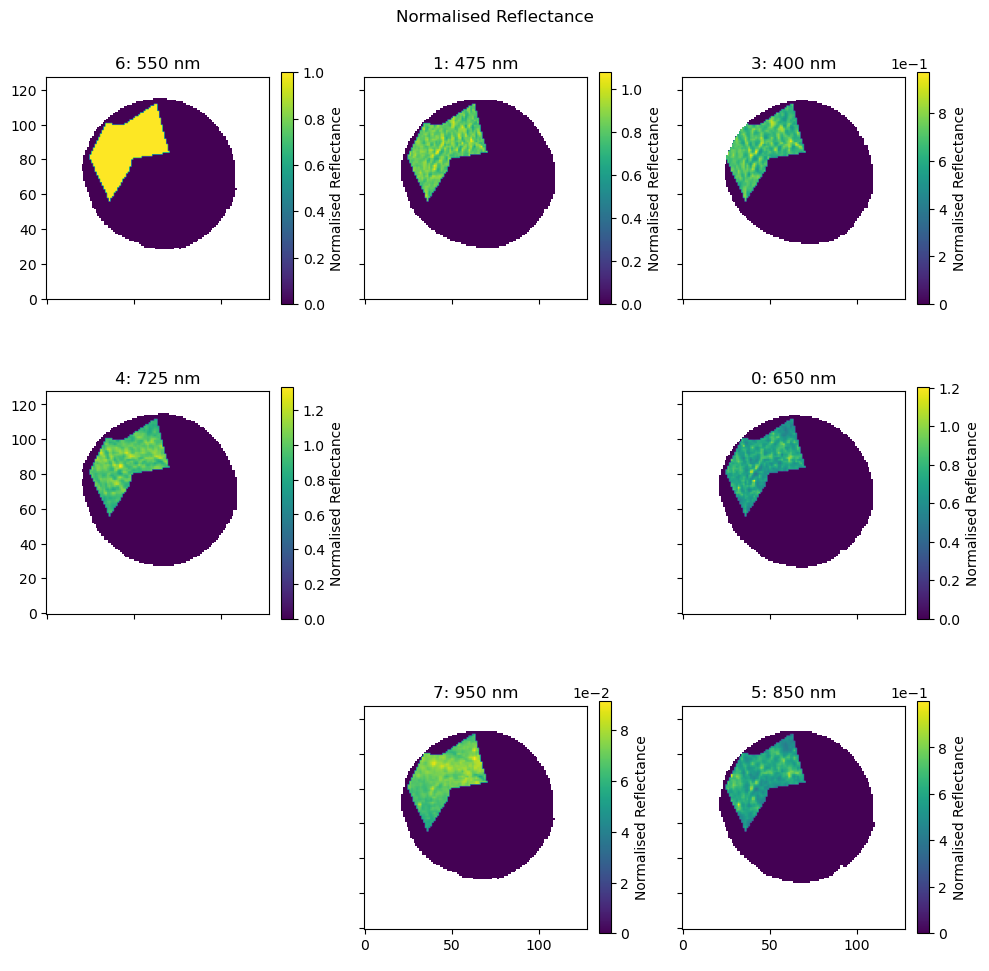

In [11]:
# optionally normalise reflectance images to 550 nm channel
channels = list(aligned_refl.keys())
base = aligned_refl['6_550']
fig, ax = grid_plot('Normalised Reflectance')
for channel in channels:
    refl = aligned_refl[channel]
    refl.normalise(base)
    refl.image_display(roi=True, polyroi=True, ax=ax[refl.camera])
show_grid(fig, ax)

And get the normalised reflectance

Average Image Mean: 0.7173837295304262 Normalised Reflectance
Average Image Std. Dev.: 0.08991396234406054 Normalised Reflectance
Noise Image Mean: 0.0006726400662138074 Normalised Reflectance
Average Image Mean: 0.821380802141803 Normalised Reflectance
Average Image Std. Dev.: 0.06562545042147337 Normalised Reflectance
Noise Image Mean: 0.0008546810643481091 Normalised Reflectance
Average Image Mean: inf Normalised Reflectance
Average Image Std. Dev.: nan Normalised Reflectance
Noise Image Mean: 0.0007074564705103388 Normalised Reflectance
Average Image Mean: 0.9807304850425774 Normalised Reflectance
Average Image Std. Dev.: 0.08384111202811333 Normalised Reflectance
Noise Image Mean: 0.0009658167895261244 Normalised Reflectance
Average Image Mean: 0.5995205130225385 Normalised Reflectance
Average Image Std. Dev.: 0.07989270533811352 Normalised Reflectance
Noise Image Mean: 0.0005379782821030322 Normalised Reflectance
Average Image Mean: 1.0 Normalised Reflectance
Average Image Std. D

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


<Axes: xlabel='cwl'>

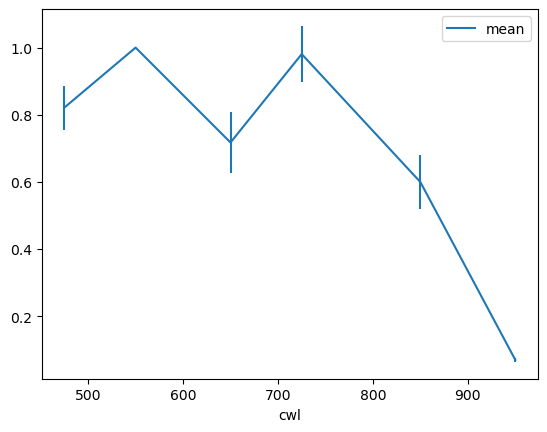

In [12]:
# get the mean and std reflectance over each ROI and plot
import pandas as pd
cwls = []
means = []
stds = []
for channel in channels:
    mean, std, _ = aligned_refl[channel].image_stats(polyroi=True)
    cwl = aligned_refl[channel].cwl
    cwls.append(cwl)
    means.append(mean)
    stds.append(std)
results = pd.DataFrame({'cwl':cwls, 'mean':means, 'std':stds})
results.sort_values(by='cwl', inplace=True)
results.plot(x='cwl', y='mean', yerr='std')

## Sample 3

Calibrating Reflectance for: 0 (650.0 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:378: RuntimeWarning: invalid value encountered in multiply
  self.img_ave = self.img_ave * cali_source.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:380: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:381: RuntimeWarning: invalid value encountered in divide
  cali_err = cali_source.img_std/cali_source.img_ave


../data/sample_3/0_650
Mean image written to ../data/sample_3/0_650/650_mean_rfl.tif
Error image written to ../data/sample_3/0_650/650_error_rfl.tif
Calibrating Reflectance for: 1 (475.0 nm)
../data/sample_3/1_475
Mean image written to ../data/sample_3/1_475/475_mean_rfl.tif
Error image written to ../data/sample_3/1_475/475_error_rfl.tif
Calibrating Reflectance for: 3 (400.0 nm)
../data/sample_3/3_400
Mean image written to ../data/sample_3/3_400/400_mean_rfl.tif
Error image written to ../data/sample_3/3_400/400_error_rfl.tif
Calibrating Reflectance for: 4 (725.0 nm)
../data/sample_3/4_725
Mean image written to ../data/sample_3/4_725/725_mean_rfl.tif
Error image written to ../data/sample_3/4_725/725_error_rfl.tif
Calibrating Reflectance for: 5 (850.0 nm)
../data/sample_3/5_850
Mean image written to ../data/sample_3/5_850/850_mean_rfl.tif
Error image written to ../data/sample_3/5_850/850_error_rfl.tif
Calibrating Reflectance for: 6 (550.0 nm)
../data/sample_3/6_550
Mean image written to 

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


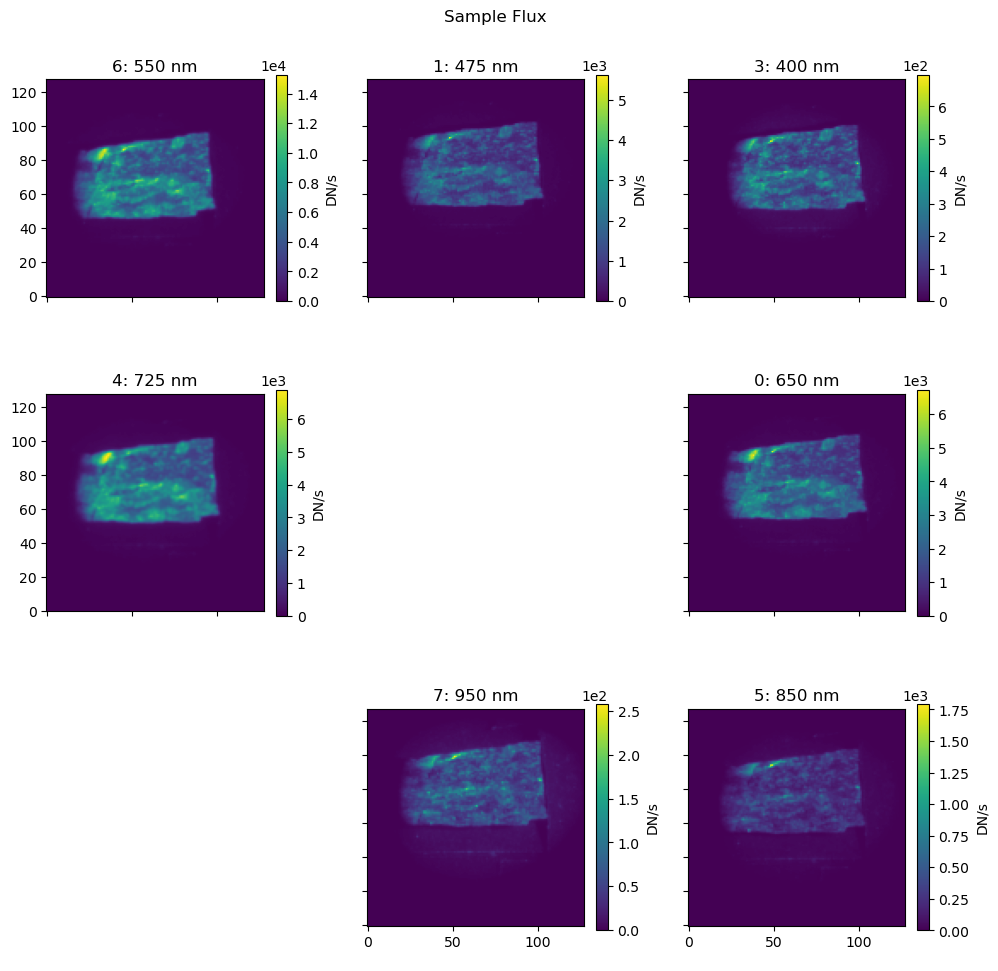

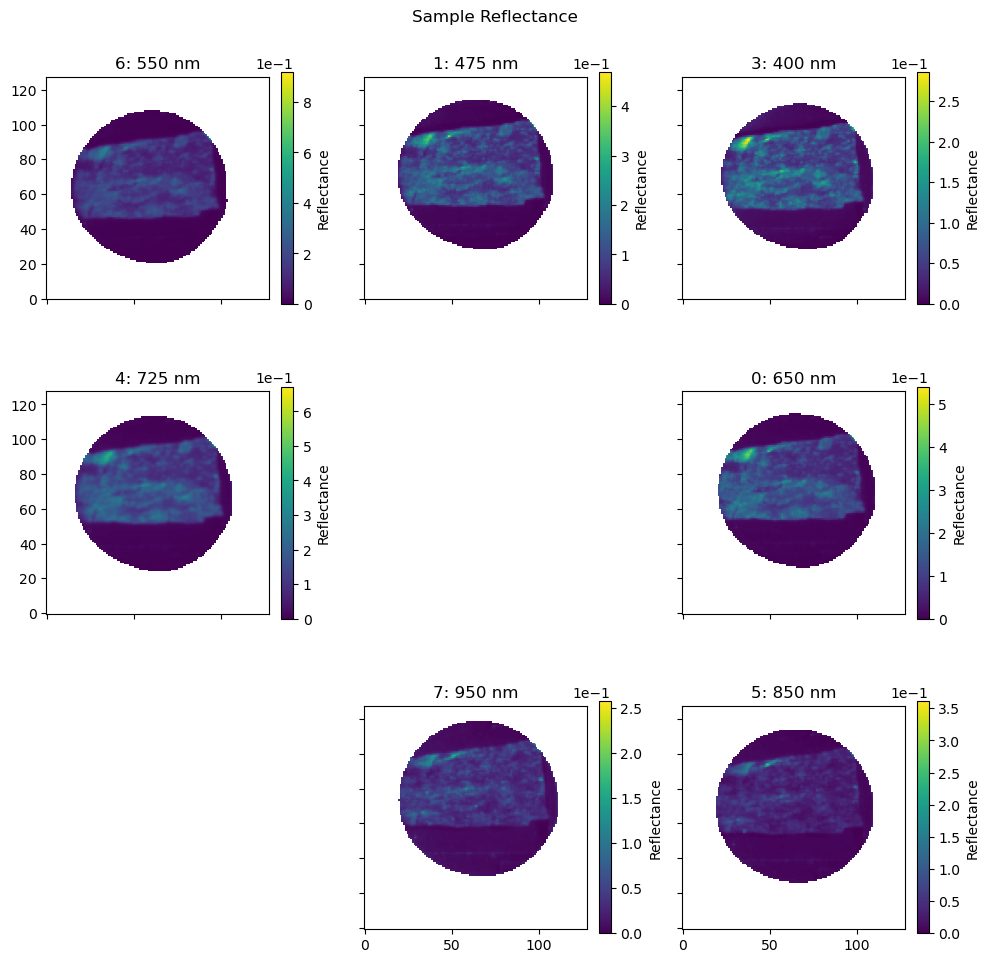

In [13]:
target = 'sample_3'
channels = sorted(list(Path('..', 'data',target).glob('[!.]*')))
reflectance = {}
samples = {}
title = 'Sample Flux'
fig1, ax1 = grid_plot(title)
title = 'Sample Reflectance'
fig, ax = grid_plot(title)
for channel_path in channels:
    channel = channel_path.name
    # load the sample images
    smpl = osp.LightImage(target, channel)
    smpl.image_load()
    print(f'Calibrating Reflectance for: {smpl.camera} ({smpl.cwl} nm)')
    # load the sample dark frames
    dark_smpl = osp.DarkImage(target, channel)
    dark_smpl.image_load()
    # subtract the dark frame
    smpl.dark_subtract(dark_smpl)
    samples[channel] = smpl
    # apply exposure correction
    smpl.correct_exposure()
    smpl.image_display(roi=True, ax=ax1[smpl.camera])
    # apply calibration coefficients
    cali_coeff = cali_coeffs[channel]
    refl = osp.ReflectanceImage(smpl)
    refl.calibrate_reflectance(cali_coeff)
    refl.image_display(roi=True, ax=ax[refl.camera])
    # save the reflectance image
    refl.save_tiff()
    reflectance[channel] = refl
show_grid(fig1, ax1)
show_grid(fig, ax)

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:548: RuntimeWarning: invalid value encountered in subtract
  src = ax.imshow(query_reg-train_img, cmap='RdBu', origin='lower', vmin=-col_max, vmax=col_max)
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: invalid value encountered in subtract
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: invalid value encountered in divide
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:552: RuntimeWarning: divide by zero encountered in divide
  err = ax.imshow(np.abs(query_reg-train_img)/train_img, origin='lower')
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matp

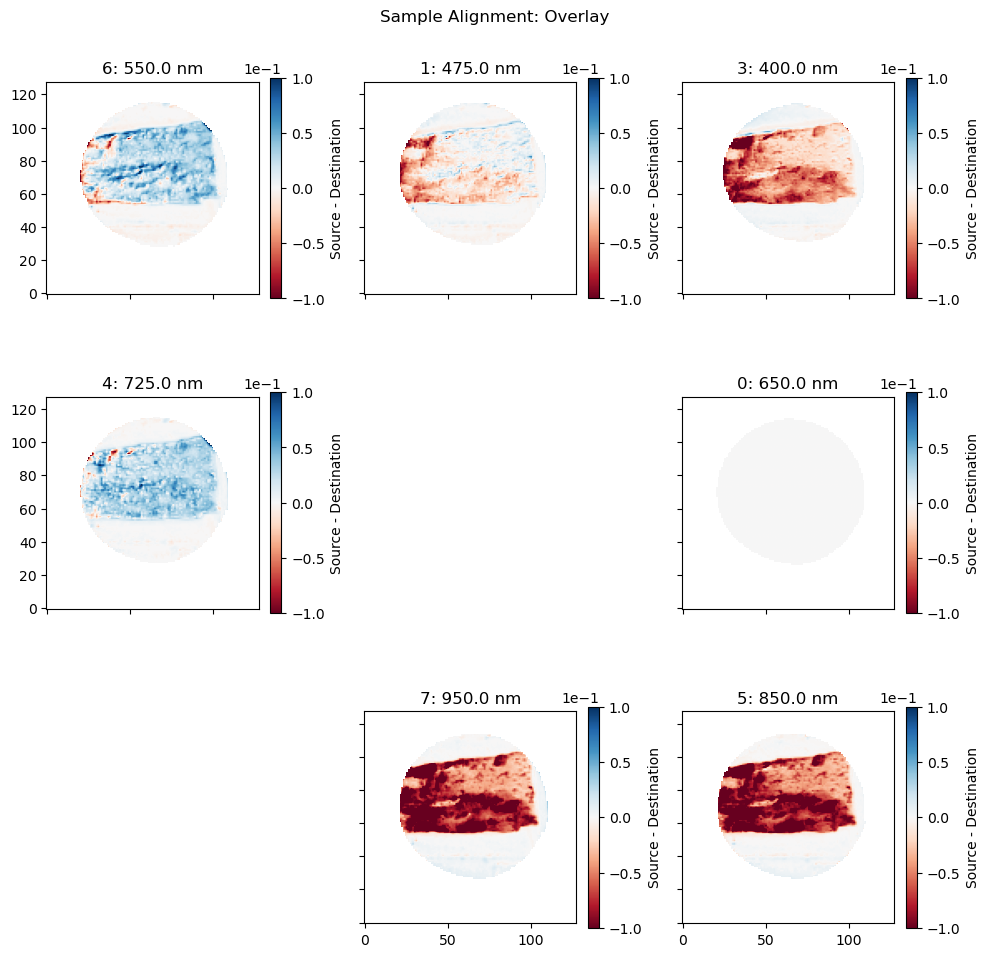

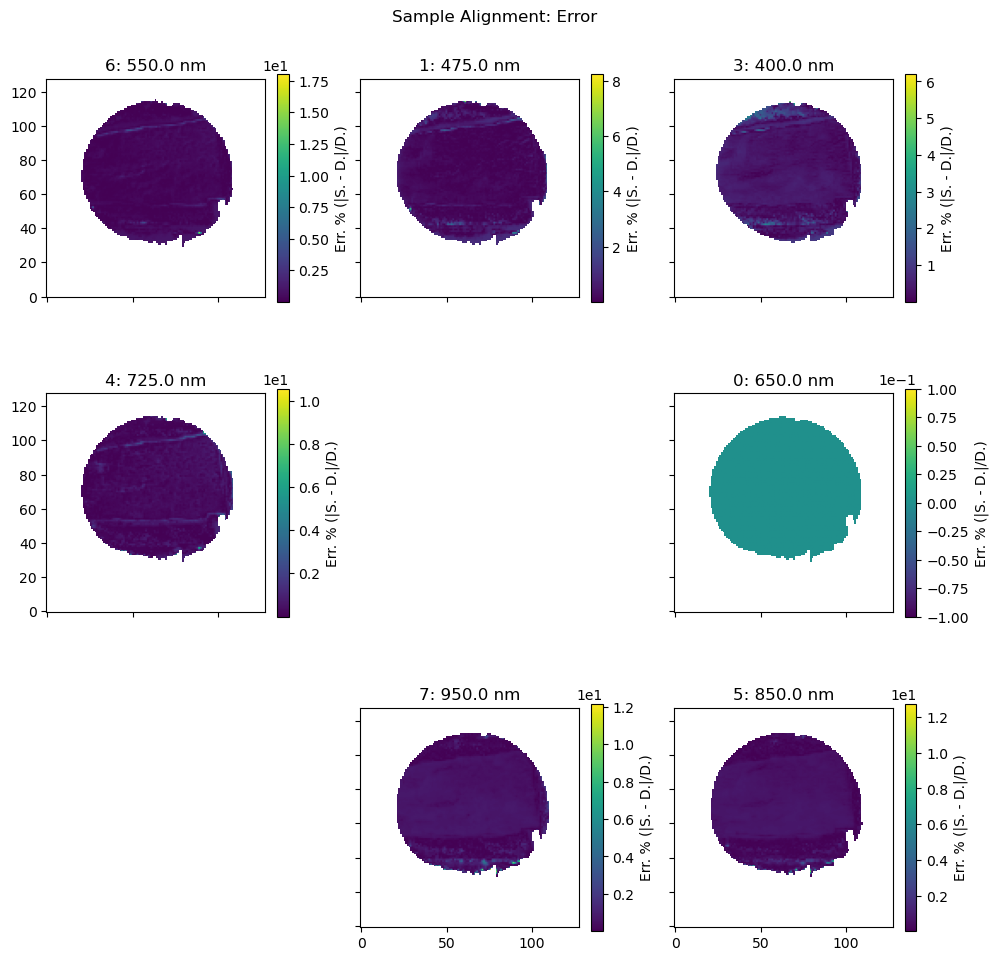

In [14]:
channels = list(reflectance.keys())
destination = channels[0]
sample_dest = reflectance[destination]
fig, ax = grid_plot('Sample Alignment: Overlay')
fig1, ax1 = grid_plot('Sample Alignment: Error')
aligned_refl = {}
for channel in channels:
    sample_src = reflectance[channel] 
    sample_coal = coals[channel]   
    src = osp.CoAlignedImage(
                sample_src, 
                destination_image=sample_dest, 
                homography=sample_coal.homography, 
                roi=False)
    src.align_images()
    src.show_alignment(overlay=True, error=False, ax=ax[src.camera], roi=True)
    src.show_alignment(overlay=False, error=True, ax=ax1[src.camera], roi=True)
    aligned_refl[channel] = osp.ReflectanceImage(src)
show_grid(fig, ax)
show_grid(fig1, ax1)

### Reflectance ROI Selection and Plotting

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:102: RuntimeWarning: invalid value encountered in multiply
  roi_img = roi_img * self.polyroi
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


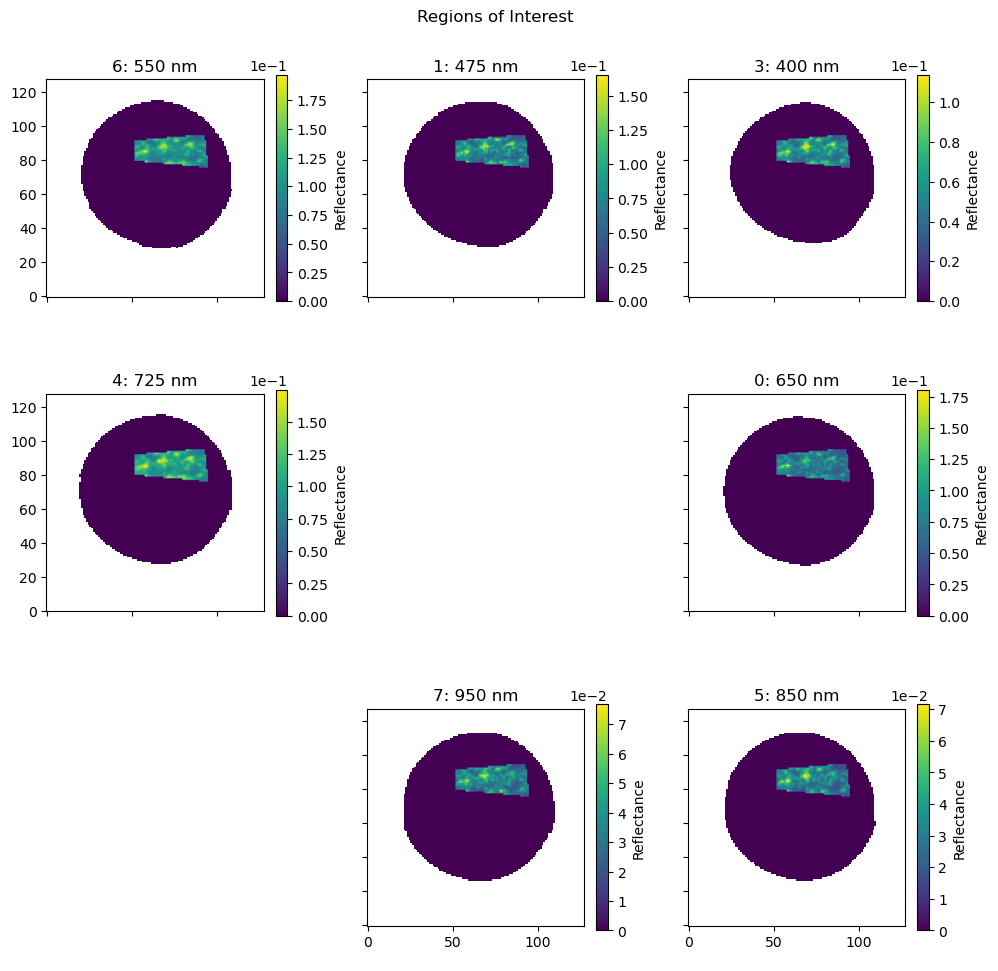

In [15]:
# set region of interest on the base channel
channels = list(aligned_refl.keys())
base = aligned_refl['6_550']
base.roi =True
base.set_polyroi()
# apply the polyroi to each channel:
fig, ax = grid_plot('Regions of Interest')
for channel in channels:
    refl = aligned_refl[channel]
    refl.polyroi = base.polyroi
    refl.image_display(roi=True,polyroi=True, ax=ax[refl.camera])
show_grid(fig, ax)

# for each warped reflectance image, set region of interest mask
# for each warped reflectance image, get average and standard deviation

Average Image Mean: 0.0783291146049611 Reflectance
Average Image Std. Dev.: 0.020358859447591117 Reflectance
Noise Image Mean: 0.0008502110489259244 Reflectance
Average Image Mean: 0.0802909508406077 Reflectance
Average Image Std. Dev.: 0.022063838812570916 Reflectance
Noise Image Mean: 0.0008062517434690899 Reflectance
Average Image Mean: 0.058045530247732464 Reflectance
Average Image Std. Dev.: 0.015464458456337529 Reflectance
Noise Image Mean: 0.0005770044790488614 Reflectance
Average Image Mean: 0.10457229322418327 Reflectance
Average Image Std. Dev.: 0.020538838806649466 Reflectance
Noise Image Mean: 0.001011074073882054 Reflectance
Average Image Mean: 0.032738394809610674 Reflectance
Average Image Std. Dev.: 0.009957016606434626 Reflectance
Noise Image Mean: 0.0003155060272540635 Reflectance
Average Image Mean: 0.10798437267531136 Reflectance
Average Image Std. Dev.: 0.02309255198141676 Reflectance
Noise Image Mean: 0.001046663868972111 Reflectance
Average Image Mean: 0.035932459

<Axes: xlabel='cwl'>

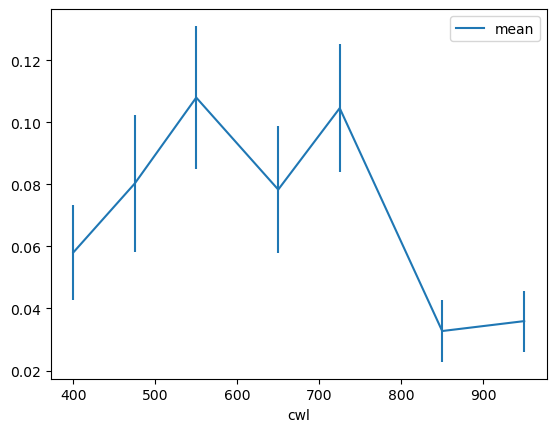

In [16]:
# get the mean and std reflectance over each ROI and plot
import pandas as pd
cwls = []
means = []
stds = []
for channel in channels:
    mean, std, _ = aligned_refl[channel].image_stats(polyroi=True)
    cwl = aligned_refl[channel].cwl
    cwls.append(cwl)
    means.append(mean)
    stds.append(std)
results = pd.DataFrame({'cwl':cwls, 'mean':means, 'std':stds})
results.sort_values(by='cwl', inplace=True)
results.plot(x='cwl', y='mean', yerr='std')

Now normalise the results

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:387: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:387: RuntimeWarning: invalid value encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:102: RuntimeWarning: invalid value encountered in multiply
  roi_img = roi_img * self.polyroi
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_13064/4127230663.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


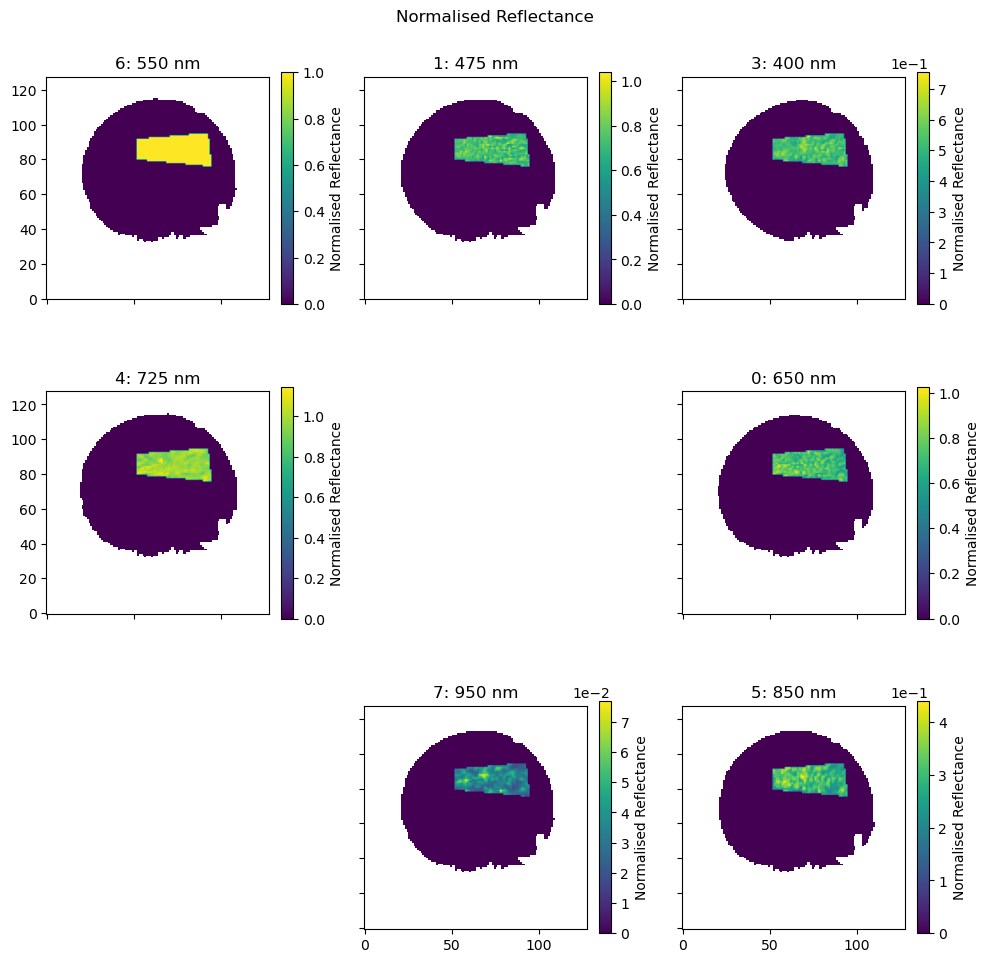

In [17]:
# optionally normalise reflectance images to 550 nm channel
channels = list(aligned_refl.keys())
base = aligned_refl['6_550']
fig, ax = grid_plot('Normalised Reflectance')
for channel in channels:
    refl = aligned_refl[channel]
    refl.normalise(base)
    refl.image_display(roi=True, polyroi=True, ax=ax[refl.camera])
show_grid(fig, ax)

And get the normalised reflectance

Average Image Mean: 0.7235755941393087 Normalised Reflectance
Average Image Std. Dev.: 0.08093862738556229 Normalised Reflectance
Noise Image Mean: 0.0008502110489259244 Normalised Reflectance
Average Image Mean: 0.7377402198926563 Normalised Reflectance
Average Image Std. Dev.: 0.07640225893831544 Normalised Reflectance
Noise Image Mean: 0.0008062517434690899 Normalised Reflectance
Average Image Mean: 0.5337777076400535 Normalised Reflectance
Average Image Std. Dev.: 0.05079213289547496 Normalised Reflectance
Noise Image Mean: 0.0005770044790488614 Normalised Reflectance
Average Image Mean: 0.9729877377575339 Normalised Reflectance
Average Image Std. Dev.: 0.05077444644025993 Normalised Reflectance
Noise Image Mean: 0.001011074073882054 Normalised Reflectance
Average Image Mean: 0.30025740907633414 Normalised Reflectance
Average Image Std. Dev.: 0.047301701313958396 Normalised Reflectance
Noise Image Mean: 0.0003155060272540635 Normalised Reflectance
Average Image Mean: 1.0 Normalised

<Axes: xlabel='cwl'>

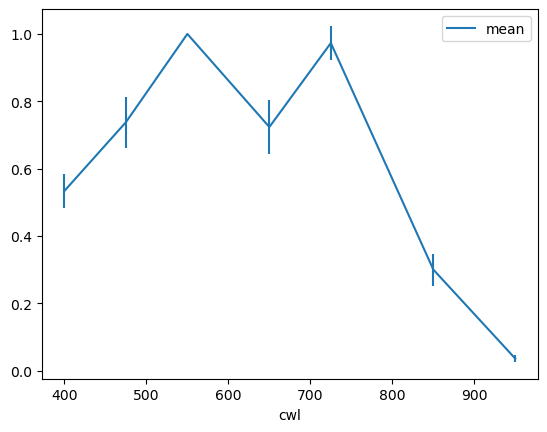

In [18]:
# get the mean and std reflectance over each ROI and plot
import pandas as pd
cwls = []
means = []
stds = []
for channel in channels:
    mean, std, _ = aligned_refl[channel].image_stats(polyroi=True)
    cwl = aligned_refl[channel].cwl
    cwls.append(cwl)
    means.append(mean)
    stds.append(std)
results = pd.DataFrame({'cwl':cwls, 'mean':means, 'std':stds})
results.sort_values(by='cwl', inplace=True)
results.plot(x='cwl', y='mean', yerr='std')